# 3. Preprocessing & Modeling

In [1]:
# install XGBoost
#!pip install xgboost

In [2]:
# install Prophet
#!pip install prophet

In [3]:
# install plotly
#!pip install plotly

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from pmdarima.arima import ADFTest
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [5]:
# load data
passenger_traffic = pd.read_csv('../datasets/passenger_traffic.csv')

passenger_traffic

,month,total_passengers
0,1989-01-01,1107283
1,1989-02-01,1050398
2,1989-03-01,1160644
3,1989-04-01,1089718
4,1989-05-01,1100198
...,...,...
407,2022-12-01,4620193
408,2023-01-01,4366912
409,2023-02-01,4002734
410,2023-03-01,4633939


In [6]:
# set 'month' column as index
passenger_traffic.set_index('month', inplace = True)

In [7]:
# convert index to datetime
passenger_traffic.index = pd.to_datetime(passenger_traffic.index)

# remove day from date in index
passenger_traffic.index = passenger_traffic.index.strftime('%Y-%m')

## 3.1 Preprocessing

### Stationarity

In [8]:
# instantiate Augmented Dickey-Fuller test
adf_test = ADFTest(alpha = 0.05)

# test if data is stationary
adf_test.should_diff(passenger_traffic['total_passengers']) 

(0.057960465218675886, True)

Since p-value > 0.05, we are unable to reject the null hypothesis that the data is not stationary. This indicates that the statistical properties (such as mean and variance) changes over time and that there are underlying trends, seasonality or other patterns that change with time. Thus, to facilitate subsequent modeling and forecasting, new columns would be created in the dataframe to store the differenced data as additional features for the modeling.

In [9]:
# create additional columns of differenced data
passenger_traffic['diff_1'] = passenger_traffic['total_passengers'].diff() # 1 month
passenger_traffic['diff_3'] = passenger_traffic['total_passengers'].diff(3) # 3 months
passenger_traffic['diff_6'] = passenger_traffic['total_passengers'].diff(6) # 6 months

passenger_traffic.head(10)

,total_passengers,diff_1,diff_3,diff_6
month,,,,
1989-01,1107283,NaN,NaN,NaN
1989-02,1050398,-56885.0,NaN,NaN
1989-03,1160644,110246.0,NaN,NaN
1989-04,1089718,-70926.0,-17565.0,NaN
1989-05,1100198,10480.0,49800.0,NaN
1989-06,1171689,71491.0,11045.0,NaN
1989-07,1222448,50759.0,132730.0,115165.0
1989-08,1240544,18096.0,140346.0,190146.0
1989-09,1195918,-44626.0,24229.0,35274.0


In [10]:
# drop na values
pax_traffic_diff = passenger_traffic.dropna()

In [11]:
# test for stationarity for data differenced by d = 1
adf_test.should_diff(pax_traffic_diff['diff_1'])

(0.01, False)

Since p-value < 0.05, we can reject the null hypothesis and conclude the data is stationary. In this case, d = 1 would be sufficient for the subsequent modeling and the other columns for d = 3 and d = 6 can be dropped.

In [12]:
# drop 'diff_3' and 'diff_6' columns
passenger_traffic = passenger_traffic.iloc[:, :-2]

### Lag interval

In determing a suitable lag interval, we first examine for patterns in passenger traffic data by breaking down the data in blocks of 10 years:
1. 1990 to 1999
2. 2000 to 2009
3. 2010 to 2019

i. Years 1990 to 1999

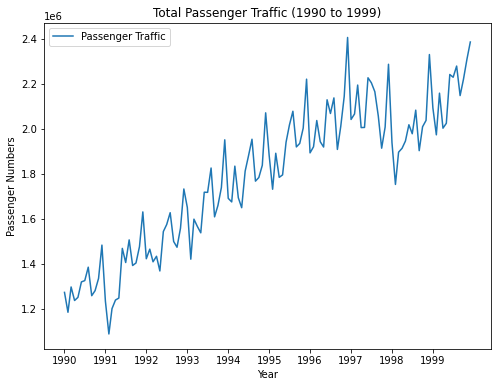

In [13]:
# filter data by decade
traffic_1990 = passenger_traffic['1990':'2000']

# convert index to datetime objects
traffic_1990.index = pd.to_datetime(traffic_1990.index)

# set figure size and create subplot
plt.figure(figsize = (8, 6))

# plot data
sns.lineplot(data = traffic_1990['total_passengers'], x = traffic_1990.index, y = traffic_1990['total_passengers'].values, label = 'Passenger Traffic')

# title and labels
plt.title('Total Passenger Traffic (1990 to 1999)')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# calculate unique years (1-year interval)
unique_years = traffic_1990.index.year.unique()

# set x-axis ticks to display unique years
plt.xticks(pd.to_datetime(unique_years, format = '%Y'), unique_years)

# show legend
plt.legend()

# show plot
plt.show()

ii. Years 2000 to 2009

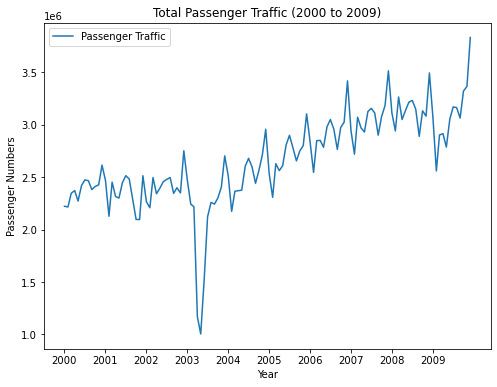

In [14]:
# filter data by decade
traffic_2000 = passenger_traffic['2000':'2010']

# convert index to datetime objects
traffic_2000.index = pd.to_datetime(traffic_2000.index)

# set figure size and create subplot
plt.figure(figsize = (8, 6))

# plot data
sns.lineplot(data = traffic_2000['total_passengers'], x = traffic_2000.index, y = traffic_2000['total_passengers'].values, label = 'Passenger Traffic')

# title and labels
plt.title('Total Passenger Traffic (2000 to 2009)')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# calculate unique years (1-year interval)
unique_years = traffic_2000.index.year.unique()

# set x-axis ticks to display unique years
plt.xticks(pd.to_datetime(unique_years, format = '%Y'), unique_years)

# show legend
plt.legend()

# show plot
plt.show()

iii. Years 2010 to 2019

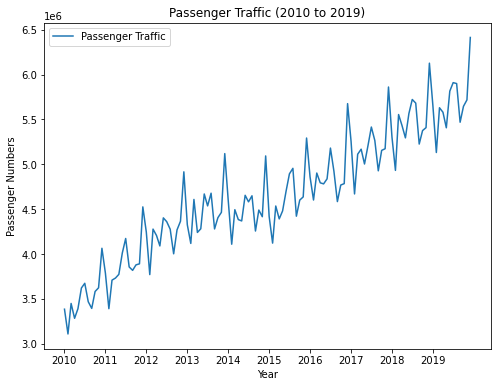

In [15]:
# filter data by decade
traffic_2010 = passenger_traffic['2010':'2020']

# convert index to datetime objects
traffic_2010.index = pd.to_datetime(traffic_2010.index)

# set figure size and create subplot
plt.figure(figsize = (8, 6))

# plot data
sns.lineplot(data = traffic_2010['total_passengers'], x = traffic_2010.index, y = traffic_2010['total_passengers'].values, label='Passenger Traffic')

# title and labels
plt.title('Passenger Traffic (2010 to 2019)')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# calculate unique years (1-year interval)
unique_years = traffic_2010.index.year.unique()

# set x-axis ticks to display unique years
plt.xticks(pd.to_datetime(unique_years, format = '%Y'), unique_years)

# Show the legend
plt.legend()

# Show the plot
plt.show()

Based on the above plots, it is observed that each year experiences a spike in mid year before going down and spiking again at the end of the year (excluding periods of drastic drop due to external factors). Thus, it may be appropriate to include a lag feature with a lag interval of 12 months to represent the annual cycle.

In [16]:
# create column for lag feature
passenger_traffic['lag_12'] = passenger_traffic['total_passengers'].shift(12)

In [17]:
# drop na values
mod_pax_traffic = passenger_traffic.dropna()

mod_pax_traffic.head()

,total_passengers,diff_1,lag_12
month,,,
1990-01,1272188,-84433.0,1107283.0
1990-02,1183722,-88466.0,1050398.0
1990-03,1296306,112584.0,1160644.0
1990-04,1236082,-60224.0,1089718.0
1990-05,1250117,14035.0,1100198.0


In [18]:
mod_pax_traffic.head(20)

,total_passengers,diff_1,lag_12
month,,,
1990-01,1272188,-84433.0,1107283.0
1990-02,1183722,-88466.0,1050398.0
1990-03,1296306,112584.0,1160644.0
1990-04,1236082,-60224.0,1089718.0
1990-05,1250117,14035.0,1100198.0
1990-06,1318779,68662.0,1171689.0
1990-07,1324661,5882.0,1222448.0
1990-08,1384333,59672.0,1240544.0
1990-09,1257513,-126820.0,1195918.0


In [19]:
mod_pax_traffic

,total_passengers,diff_1,lag_12
month,,,
1990-01,1272188,-84433.0,1107283.0
1990-02,1183722,-88466.0,1050398.0
1990-03,1296306,112584.0,1160644.0
1990-04,1236082,-60224.0,1089718.0
1990-05,1250117,14035.0,1100198.0
...,...,...,...
2022-12,4620193,656898.0,817092.0
2023-01,4366912,-253281.0,719926.0
2023-02,4002734,-364178.0,702917.0


### Dataset split

As all columns in the dataframe are already in the same unit of measurement, there would be no need for standardisation and the train-test split can be done directly.

In [20]:
# calculate the index for splitting
split_index = int(len(mod_pax_traffic) * 0.7)

# split the sorted data into train and test sets
train_data = mod_pax_traffic.iloc[:split_index]
test_data = mod_pax_traffic.iloc[split_index:]

# separate features and target variable
X_train = train_data.drop(columns = ['total_passengers'])
y_train = train_data['total_passengers']

X_test = test_data.drop(columns = ['total_passengers'])
y_test = test_data['total_passengers']

## 3.2 Modeling (Part 1)

### 3.2.1 Linear regression

In [21]:
# instantiate
lr = LinearRegression()

# fit model
lr.fit(X_train, y_train)

# predict on test
y_pred_lr = lr.predict(X_test)

# MAPE on train
mape_train_lr = cross_val_score(lr, 
                           X_train, 
                           y_train, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_percentage_error')

# MAPE on test
mape_test_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test))

print(f'MAPE (train): {np.mean(np.abs(mape_train_lr))}')
print(f'MAPE (test): {np.mean(mape_test_lr)}')

MAPE (train): 0.07270371965400732
MAPE (test): 8.585749005961267


In [22]:
# create df to store coefficients
lr_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr.coef_})

lr_coef

,Feature,Coefficient
0,diff_1,0.196334
1,lag_12,1.027348


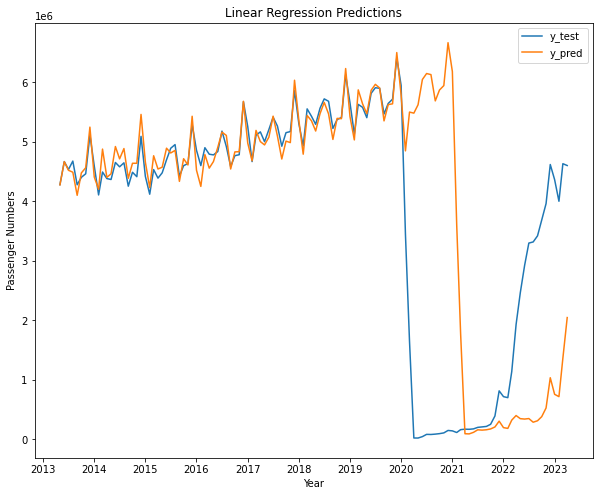

In [23]:
# plot testing data against predictions
# convert index to datetime objects
y_test.index = pd.to_datetime(y_test.index)

# set figure size and create subplot
plt.figure(figsize = (10, 8))
ax = plt.subplot()

# plot test data
sns.lineplot(x = y_test.index, y = y_test, label = 'y_test', ax = ax)

# plot predictions
sns.lineplot(x = y_test.index, y = y_pred_lr, label = 'y_pred', ax = ax)

# title and labels
plt.title('Linear Regression Predictions')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# legend
plt.legend()

# show plot
plt.show()

#### Check assumptions (L, I, N, E, M)

i. Linearity

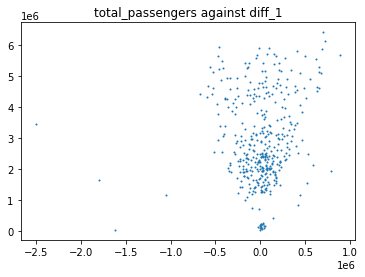

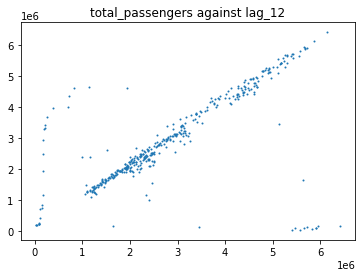

In [24]:
for col in mod_pax_traffic.iloc[:,1:3].columns:
    plt.title(f'total_passengers against {col}')
    plt.scatter(mod_pax_traffic[col], mod_pax_traffic['total_passengers'], s = 1)
    plt.show()

The linearity assumption assumes that there is a linear relationship between the features and target variable. In this case, linear relationship can only be observed with the feature 'lag_12' which contains the lagged values of interval = 12.

ii. Independence

The dataset records the factual observations of passenger traffic (for arrival, departure and transit) and thus, fulfils the independence assumption.

iii. Normality of errors

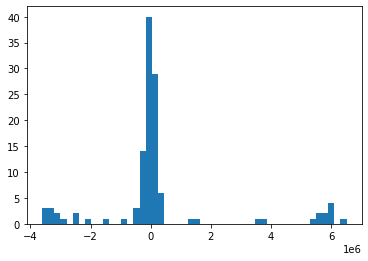

In [25]:
resid = y_pred_lr - y_test
plt.hist(resid, bins = 50)

plt.show()

Based on the above histogram, it is observed that errors are not normally distributed.

iv. Equal variance of errors

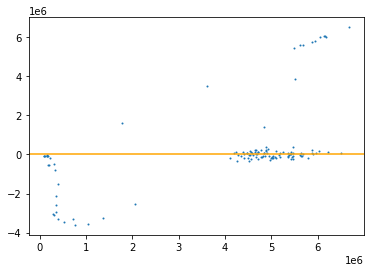

In [26]:
plt.scatter(y_pred_lr, resid, s = 1)
plt.axhline(0, color = 'orange')

plt.show()

Based on the above scatterplot, the residuals are mostly negative with quite a few outliers which would affect the regression line and thereby affecting the model's ability to predict well.

v. Multicollinearity

In [27]:
corr_matrix = X_train.corr()
high_corr = ((corr_matrix > 0.7) & (corr_matrix < 1)).any()

# filter out False observations
high_corr_true = high_corr[high_corr == True]

high_corr_true

Series([], dtype: bool)

The two features added to represent differenced and lagged values respectively are not highly correlated with each other.

##### Model summary and performance successes / downfalls

While linear regression appears to be the simplest kind of forecasting due to model's interpretability and ease of implementation, we improved its ability to handle time series data by introducing lagged and differenced values. However, such model may still face difficulties in effectively capturing non-linear relationships and temporal dependencies in the data.

Here, the train MAPE is relatively small at about 0.0727, the test MAPE is a lot larger at about 8.59 despite utilising cross validation to minimise overfitting. Nonetheless, plotting the predicted values against the true (test) values shows that the patterns of the predictions seem to be able to trace that of the true values relatively well.

On the additional features (differenced and lagged values), both coefficients are positive which suggest that a positive change in the differenced value or lagged value would contribute to a positive change in the target variable of total passenger traffic (and vice versa). However, it appears that the differenced values have a smaller influence on the target variable in view of the much small coefficient of about 0.196 as compared to the coefficient of the lagged values of 1.03.

### 3.2.2 XGBoost

In [28]:
# instantiate
xgb = XGBRegressor(n_estimators = 25, max_depth = 5)

# fit on train
xgb.fit(X_train, y_train)

# predict on test
y_pred_xgb = xgb.predict(X_test)

# MAPE on train
mape_train_xgb = cross_val_score(xgb, 
                           X_train, 
                           y_train, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_percentage_error')

# MAPE on test
mape_test_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test))

print(f'MAPE (train): {np.mean(np.abs(mape_train_xgb))}')
print(f'MAPE (test): {np.mean(mape_test_xgb)}')

MAPE (train): 0.2014497259833417
MAPE (test): 7.364983621298659


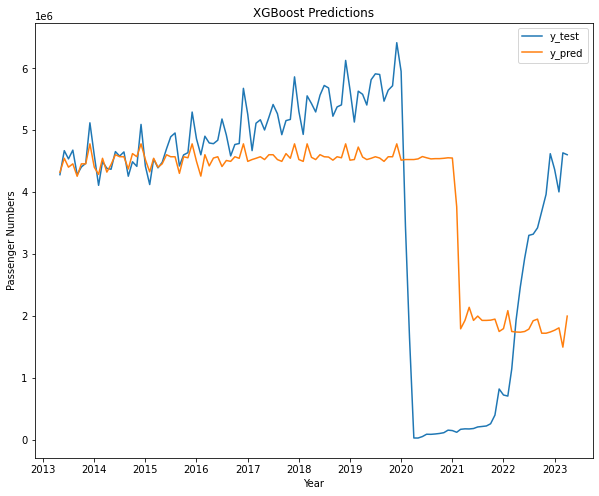

In [29]:
# plot testing data against predictions
# convert index to datetime objects
y_test.index = pd.to_datetime(y_test.index)

# set figure size and create subplot
plt.figure(figsize = (10, 8))
ax = plt.subplot()

# plot test data
sns.lineplot(x = y_test.index, y = y_test, label = 'y_test', ax = ax)

# plot predictions
sns.lineplot(x = y_test.index, y = y_pred_xgb, label = 'y_pred', ax = ax)

# title and labels
plt.title('XGBoost Predictions')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# legend
plt.legend()

# show plot
plt.show()

##### Model summary and performance successes / downfalls

The XGBoost model works by utilising an ensemble of decision trees and gradient boosting to make predictions, which allows it to capture complex relationships and handle non-linear patterns in the time series data. The ensemble learning nature of the model also allows it to improve its overall performance through minimising overfitting and improving generalisation. However, it is a complex model that is challenging to interpret when compared to other simpler models such as linear regression.

When applied onto the time series data here, the XGBoost model gives a train MAPE score of about 0.201 and test MAPE score of 7.36. While the test MAPE score is lower than that of the linear regression model, the plot of the predicted values against the true (test) values reveals that the model seems to have difficulties in capturing the pattern in the data and deviates from the true values rather significantly. Thus, this explains the significant train MAPE score of 0.201 and it could be concluded that the XGBoost model may not be the best suited for this set of time series data.

### 3.2.3 Prophet

Developed by Facebook, Prophet is a time series forecasting model that can handle non-linear trends with yearly, weekly, seasonality and holiday effects. It also works well with missing data, changes in trend and presence of outliers. In this case, there would be no need to introduce differenced or lagged values as additional features. Thus, the train-test split would be done on the original passenger_traffic dataframe with just the 'total_passengers' column.

In [30]:
# define dataframe
pax_traffic = pd.DataFrame(passenger_traffic['total_passengers'])

The model requires the dataframe to have columns 'ds' and 'y' with the dates and values respectively and thus, the index (containing the year and month) would have to be converted to a regular column. The subsequent 'ds' column also has to be in datetime format.

In [31]:
# convert index to regular column
pax_traffic = pax_traffic.reset_index()

# rename columns
prop_col_names = { 'month': 'ds', 'total_passengers': 'y'}
pax_traffic.rename(columns = prop_col_names, inplace = True)

In [32]:
# check dtype
pax_traffic.dtypes

ds    object
y      int64
dtype: object

In [33]:
# convert 'ds' column to datetime
pax_traffic['ds'] = pd.to_datetime(pax_traffic['ds'])

Train-test split

In [34]:
# define train size
train_size = int(0.7 * len(pax_traffic))

# train-test split
train_data_prop = pax_traffic[:train_size]
test_data_prop = pax_traffic[train_size:]

Modeling

In [35]:
# instantiate
prop = Prophet()

# fit on train
prop.fit(train_data_prop)

# predict on test
future = prop.make_future_dataframe(periods = len(test_data_prop), freq = 'MS')
forecast = prop.predict(future)

15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# pred on test
pred_values = forecast[-len(test_data_prop):]['yhat']

# actual values from test set
actual_values = test_data_prop['y']

In [37]:
# calculate MAPE
def calculate_mape(y_true, y_pred):
    return (abs((y_true - y_pred) / y_true)).mean()

mape_prop = calculate_mape(test_data_prop['y'], forecast[-len(test_data_prop):]['yhat'])

mape_prop

10.85085910297487

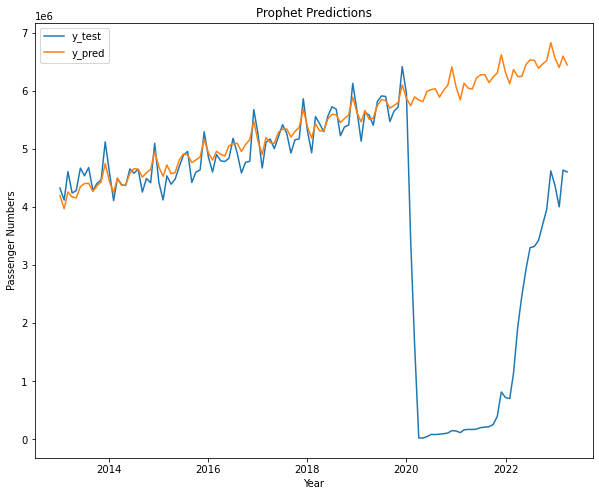

In [38]:
# plot testing data against predictions
# set figure size and create subplot
plt.figure(figsize = (10, 8))
ax = plt.subplot()

# plot test data
sns.lineplot(x = test_data_prop['ds'], y = actual_values, label = 'y_test', ax = ax)

# plot predictions
sns.lineplot(x = test_data_prop['ds'], y = pred_values, label = 'y_pred', ax = ax)

# title and labels
plt.title('Prophet Predictions')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# legend
plt.legend()

# show plot
plt.show()

##### Model summary and performance successes / downfalls

Prophet is a user-friendly and easily implemented model for time series data which can automatically handles non-linear trends including seasonality, as mentioned earlier. However, it may not be effective for patterns which are too complex or irregular.

Applying Prophet here gives a rather significant test MAPE score of about 10.9, which is even higher than that of the earlier XGBoost model. Plotting the predicted values against the true (test) values reveals that while the model is able to produce predictions which closely follow the minor fluctuations, it was unable to react to the sudden drastic decrease and continued to predict an increasing trend with the same set of minor fluctuations for each year. This finding concurs with the earlier point that Prophet is unable to handle patterns which are inrregular in nature such as the sudden drop seen here.

## 3.3 Modeling (Part 2)

All of the above 3 models performed consistently badly on the test set and this could be attributed to the fact that the data in the train set are relatively stable in nature while the data in the test set contain drastic drops due to the halt in air travel during the pandemic which is a sudden and unexpected occurence. Such drastic fluctuations could potentially affect modeling accuracy significantly and lead to challenges in model tuning and objective assessments of different models' performances.

To facilitate objective assessment of the model's performance, the time series data to be used in this second run would be truncated to only retain data before the halt in air travel in 2020.

In [39]:
# check for month in which the drastic drop in passenger traffic occurred
check_month = ['2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05']

mod_pax_traffic[mod_pax_traffic.index.isin(check_month)]['total_passengers']

month
2019-12    6414495
2020-01    5950940
2020-02    3446022
2020-03    1649662
2020-04      25189
2020-05      24504
Name: total_passengers, dtype: int64

From the above filtered data, a steady decline in passenger traffic can be observed from December 2019 to March 2020 before a drastic decline in April 2020. This coincides with the implementation of circuit breaker restrictions in Singapore on 7 April 2020 in an attempt to control the spread of the virus [[1]](https://www.straitstimes.com/singapore/health/two-years-after-covid-19-circuit-breaker-spore-in-better-shape-but-not-out-of-the-woods-pm-lee). Thus, the time series data shall be truncated up till March 2020 for the second run of modeling.

### 3.3.1 Linear regression

In [40]:
# remove last 37 rows of data
mod_pax_traffic_v1 = mod_pax_traffic.drop(mod_pax_traffic.index[-37:])

mod_pax_traffic_v1.tail()

,total_passengers,diff_1,lag_12
month,,,
2019-11,5718386,71743.0,5408993.0
2019-12,6414495,696109.0,6127843.0
2020-01,5950940,-463555.0,5656076.0
2020-02,3446022,-2504918.0,5131807.0
2020-03,1649662,-1796360.0,5630780.0


In [41]:
# train-test split
# calculate the index for splitting
split_index_1 = int(len(mod_pax_traffic_v1) * 0.7)

# split the sorted data into train and test sets
train_data_1 = mod_pax_traffic_v1.iloc[:split_index_1]
test_data_1 = mod_pax_traffic_v1.iloc[split_index_1:]

# separate features and target variable
X1_train = train_data_1.drop(columns = ['total_passengers'])
y1_train = train_data_1['total_passengers']

X1_test = test_data_1.drop(columns = ['total_passengers'])
y1_test = test_data_1['total_passengers']

In [42]:
# instantiate
lr_1 = LinearRegression()

# fit model
lr_1.fit(X1_train, y1_train)

# predict on test
y1_pred_lr = lr_1.predict(X1_test)

# MAPE on train
mape_train_lr_1 = cross_val_score(lr_1, 
                           X1_train, 
                           y1_train, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_percentage_error')

# MAPE on test
mape_test_lr_1 = np.mean(np.abs((y1_test - y1_pred_lr) / y1_test))

print(f'MAPE (train): {np.mean(np.abs(mape_train_lr_1))}')
print(f'MAPE (test): {np.mean(mape_test_lr_1)}')

MAPE (train): 0.07386472151155024
MAPE (test): 0.0731188312137866


In [43]:
# create df to store coefficients
lr_1_coef = pd.DataFrame({'Feature': X1_train.columns, 'Coefficient': lr_1.coef_})

lr_1_coef

,Feature,Coefficient
0,diff_1,0.211390
1,lag_12,0.955385


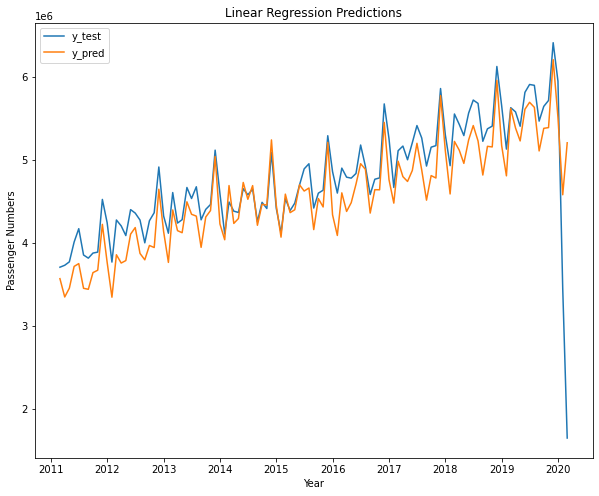

In [44]:
# plot testing data against predictions
# convert index to datetime objects
y1_test.index = pd.to_datetime(y1_test.index)

# set figure size and create subplot
plt.figure(figsize = (10, 8))
ax = plt.subplot()

# plot test data
sns.lineplot(x = y1_test.index, y = y1_test, label = 'y_test', ax = ax)

# plot predictions
sns.lineplot(x = y1_test.index, y = y1_pred_lr, label = 'y_pred', ax = ax)

# title and labels
plt.title('Linear Regression Predictions')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# legend
plt.legend()

# show plot
plt.show()

#### Check assumptions (L, I, N, E, M)

i. Linearity

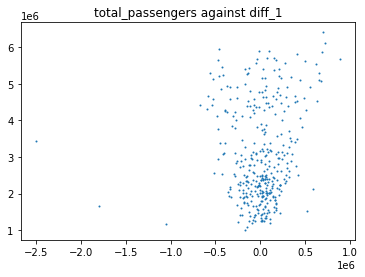

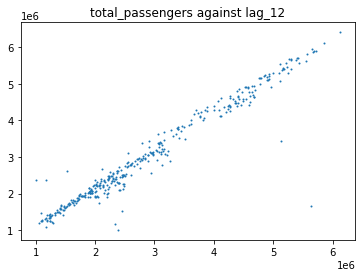

In [45]:
for col in mod_pax_traffic_v1.iloc[:,1:3].columns:
    plt.title(f'total_passengers against {col}')
    plt.scatter(mod_pax_traffic_v1[col], mod_pax_traffic_v1['total_passengers'], s = 1)
    plt.show()

Similar to the earlier linear regression model, linear relationship can only be observed with the feature 'lag_12'.

ii. Independence

This assumption has been satisfied based on the earlier assumption check under Section 3.2.1.

iii. Normality of errors

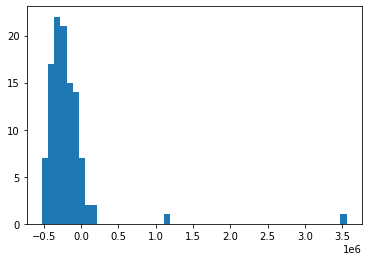

In [46]:
resid_1 = y1_pred_lr - y1_test
plt.hist(resid_1, bins = 50)

plt.show()

Based on the above histogram, it is observed that errors are not normally distributed.

iv. Equal variance of errors

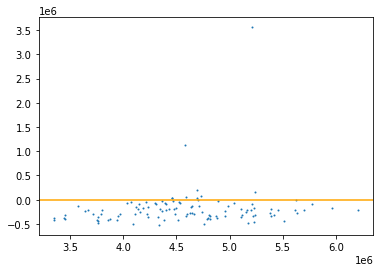

In [47]:
plt.scatter(y1_pred_lr, resid_1, s = 1)
plt.axhline(0, color = 'orange')

plt.show()

Based on the above scatterplot, the residuals are mostly negative with only a few outliers.

v. Multicollinearity

In [48]:
corr_matrix_1 = X1_train.corr()
high_corr_1 = ((corr_matrix_1 > 0.7) & (corr_matrix_1 < 1)).any()

# filter out False observations
high_corr_true_1 = high_corr_1[high_corr_1 == True]

high_corr_true_1

Series([], dtype: bool)

The two features are not highly correlated with each other.

##### Model summary and performance successes / downfalls

When applying the linear regression model on the truncated dataset, it becomes apparent that there is a vast improvement in the model's accuracy based on the MAPE scores of about 0.074 and 0.073 for train and test respectively. The difference between the train and test scores and relatively small and is thus, indicative of the model's positive performance. A review of the plot of predicted values against the true (test) values also supports this conclusion as the predictions are able to trace the patterns of the true values relatively well.

### 3.3.2 XGBoost

In [49]:
# instantiate
xgb_1 = XGBRegressor(n_estimators = 50, max_depth = 10)

# fit on train
xgb_1.fit(X1_train, y1_train)

# predict on test
y1_pred_xgb = xgb_1.predict(X1_test)

# MAPE on train
mape_train_xgb_1 = cross_val_score(xgb_1, 
                           X1_train, 
                           y1_train, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_percentage_error')

# MAPE on test
mape_test_xgb_1 = np.mean(np.abs((y1_test - y1_pred_xgb) / y1_test))

print(f'MAPE (train): {np.mean(np.abs(mape_train_xgb_1))}')
print(f'MAPE (test): {np.mean(mape_test_xgb_1)}')

MAPE (train): 0.1858711552411127
MAPE (test): 0.19786479057118825


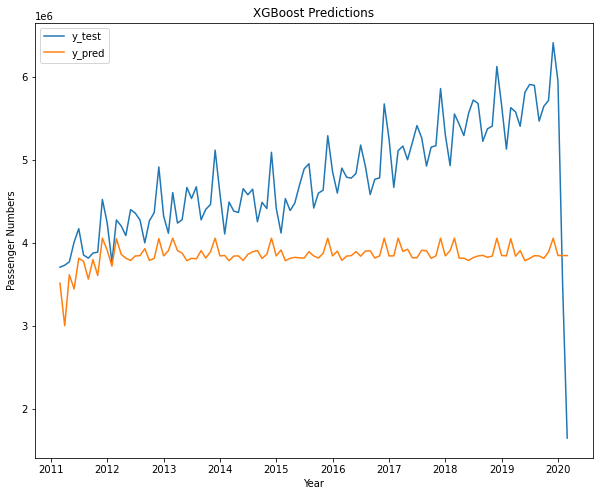

In [50]:
# plot testing data against predictions
# set figure size and create subplot
plt.figure(figsize = (10, 8))
ax = plt.subplot()

# plot test data
sns.lineplot(x = y1_test.index, y = y1_test, label = 'y_test', ax = ax)

# plot predictions
sns.lineplot(x = y1_test.index, y = y1_pred_xgb, label = 'y_pred', ax = ax)

# title and labels
plt.title('XGBoost Predictions')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# legend
plt.legend()

# show plot
plt.show()

##### Model summary and performance successes / downfalls

While the train MAPE score is relatively similar with the earlier XGBoost run in Section 3.2.2, this model performs significantly better on the test set with a test MAPE score of about 0.20. However, it remains inferior when compared to the earlier linear regression run due to its significantly higher test MAPE score.

By plotting the predictions against the true (test) values, it becomes visually apparent that the model managed to capture some of the fluctuations in the predictions but failed to capture the general increasing trend despite being fed a truncated dataset and thereby contributing to the rather significant MAPE test score. Thus, it may be concluded that a decision tree-based model may not be suitable for time series forecasting.

### 3.3.3 Prophet

Truncate dataset by removing the last 37 rows of data

In [51]:
pax_traffic_v1 = pax_traffic.drop(pax_traffic.index[-37:])

pax_traffic_v1.tail()

,ds,y
370,2019-11-01,5718386
371,2019-12-01,6414495
372,2020-01-01,5950940
373,2020-02-01,3446022
374,2020-03-01,1649662


Perform train-test split

In [52]:
# define train size
train_size_1 = int(0.7 * len(pax_traffic))

# train-test split
train_data_prop_1 = pax_traffic_v1[:train_size_1]
test_data_prop_1 = pax_traffic_v1[train_size_1:]

Modeling

In [53]:
# instantiate
prop_1 = Prophet()

# fit on train
prop_1.fit(train_data_prop_1)

# predict on test
future_1 = prop_1.make_future_dataframe(periods = len(test_data_prop_1), freq = 'MS')
forecast_1 = prop_1.predict(future_1)

15:20:09 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
# pred on test
pred_values_1 = forecast_1[-len(test_data_prop_1):]['yhat']

# actual values from test set
actual_values_1 = test_data_prop['y']

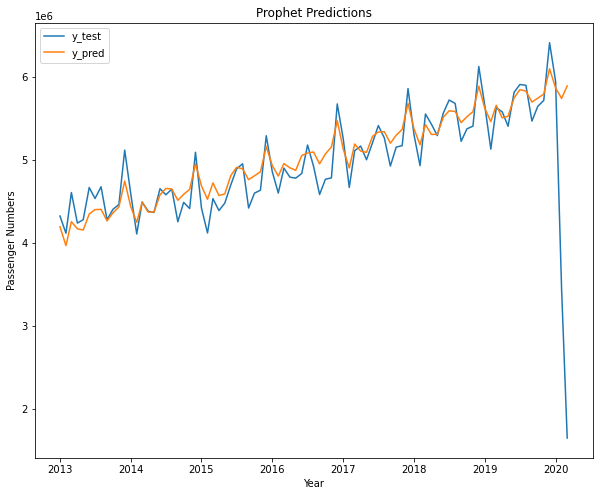

In [55]:
# plot testing data against predictions
# set figure size and create subplot
plt.figure(figsize = (10, 8))
ax = plt.subplot()

# plot test data
sns.lineplot(x = test_data_prop_1['ds'], y = actual_values_1, label = 'y_test', ax = ax)

# plot predictions
sns.lineplot(x = test_data_prop_1['ds'], y = pred_values_1, label = 'y_pred', ax = ax)

# title and labels
plt.title('Prophet Predictions')
plt.xlabel('Year')
plt.ylabel('Passenger Numbers')

# legend
plt.legend()

# show plot
plt.show()

In [56]:
# calculate MAPE
mape_prop_1 = calculate_mape(test_data_prop_1['y'], forecast_1[-len(test_data_prop_1):]['yhat'])

mape_prop_1

0.0668282884832711

##### Model summary and performance successes / downfalls

Similarly for Prophet, truncating the dataset to remove the irregularity has vastly improved the modeling outcome as the test MAPE score has been reduced to about 0.0668. The above plot also shows that the predictions are able to trace the actual test values relatively closely which further explains the low test MAPE score.

## 3.4 Selection of production model

Based on the modeling done in Sections 3.2 and 3.3, the performance of the models are summarised in the table below (MAPE scores are rounded to 3 significant figures).

| |Linear Regression|XGBoost|Prophet|
|:---|:---|:---|:---|
|MAPE (Test, before truncating dataset)|8.59|7.36|10.9|
|MAPE (Test, after truncating dataset)|0.0731|0.198|0.0668|

In summary, we can see that all 3 models are badly affected by irregularities in the time series dataset. By truncating the dataset to artifically eliminate the irregularity and objectively assess the each model's performance, we find that the Prophet model has performed the best in view of its lowest test MAPE score of 0.0668. Thus, the Prophet model would be selected as the production model in this case.

### 3.4.1 Forecasting of air passenger traffic in mid-2030

The COVID-19 pandemic has left a lasting impact on air travel and has dampened the air passenger traffic significantly. As air travel demand returns in the midst of the pandemic's aftermath, air passenger traffic is expected to return to pre-pandemic level by 2024 [[2]](https://www.straitstimes.com/singapore/politics/passenger-traffic-at-changi-airport-expected-to-recover-fully-by-2024-or-possibly-earlier-iswaran#:~:text=Giving%20this%20update%20on%20Friday,recovered%20fully%20since%20January%202023.). Assuming that the increase in air passenger traffic follows the pre-pandemic trend, the traffic in mid-2030 could be estimated by assigning the early 2020 (pre-pandemic period) as January 2024 and by forecasting 78 months into the future to arrive at (pseudo) mid-2030 (i.e., June 2030).

#### Forecasting using truncated data (assuming absence of COVID-19) 

In [74]:
# instantiate
prop_2 = Prophet()

# fit on train
prop_2.fit(pax_traffic_v1)

# predict using Prophet
future_v1 = prop_2.make_future_dataframe(periods = 78, freq = 'MS')
forecast_v1 = prop_2.predict(future_v1)

16:36:17 - cmdstanpy - INFO - Chain [1] start processing
16:36:17 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
forecast_v1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1989-01-01,1.138252e+06,8.483642e+05,1.604515e+06,1.138252e+06,1.138252e+06,81425.870351,81425.870351,81425.870351,81425.870351,81425.870351,81425.870351,0.0,0.0,0.0,1.219678e+06
1,1989-02-01,1.146802e+06,6.245048e+05,1.385087e+06,1.146802e+06,1.146802e+06,-139320.352328,-139320.352328,-139320.352328,-139320.352328,-139320.352328,-139320.352328,0.0,0.0,0.0,1.007482e+06
2,1989-03-01,1.154524e+06,6.596471e+05,1.395654e+06,1.154524e+06,1.154524e+06,-107406.481612,-107406.481612,-107406.481612,-107406.481612,-107406.481612,-107406.481612,0.0,0.0,0.0,1.047118e+06
3,1989-04-01,1.163074e+06,7.543282e+05,1.558599e+06,1.163074e+06,1.163074e+06,-8458.998748,-8458.998748,-8458.998748,-8458.998748,-8458.998748,-8458.998748,0.0,0.0,0.0,1.154615e+06
4,1989-05-01,1.171348e+06,7.722395e+05,1.467995e+06,1.171348e+06,1.171348e+06,-51727.924327,-51727.924327,-51727.924327,-51727.924327,-51727.924327,-51727.924327,0.0,0.0,0.0,1.119620e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,2026-05-01,6.866700e+06,6.404435e+06,7.167732e+06,6.771534e+06,6.956130e+06,-93391.657745,-93391.657745,-93391.657745,-93391.657745,-93391.657745,-93391.657745,0.0,0.0,0.0,6.773308e+06
449,2026-06-01,6.884140e+06,6.596329e+06,7.350348e+06,6.787249e+06,6.976017e+06,114541.303976,114541.303976,114541.303976,114541.303976,114541.303976,114541.303976,0.0,0.0,0.0,6.998681e+06
450,2026-07-01,6.901018e+06,6.702444e+06,7.476056e+06,6.802211e+06,6.995133e+06,182041.189136,182041.189136,182041.189136,182041.189136,182041.189136,182041.189136,0.0,0.0,0.0,7.083059e+06
451,2026-08-01,6.918458e+06,6.708676e+06,7.445800e+06,6.817953e+06,7.015386e+06,161611.153391,161611.153391,161611.153391,161611.153391,161611.153391,161611.153391,0.0,0.0,0.0,7.080069e+06


The forecasted air passenger traffic in (pseudo) June 2030 would reach 6,874,936 and this leads to an estimated annual number of 82,499,232 passengers passing through Changi Airport. With the completion of Terminal 5 in mid-2030, Changi Airport's total annual passenger handling capacity would be increased up to 135,000,000 [[3]](https://www.airport-technology.com/projects/terminal-5-changi-international-airport/). Thus, it can be concluded that Changi Airport would be well-equipped to handle the forecasted growth in air travel with the completion of Terminal 5 and with ample headroom for further growth.

### 3.4.2 Forecasting of air passenger traffic reaching 135 million

Assuming that the air passenger traffic remains on the increasing trend and the lack of external factors significantly affecting the traffic numbers, the same Prophet model could also be used to forecast when the traffic would outgrow the airport's passenger handling capacity.

Based on the annual handling capacity of 135,000,000, an estimated 11,250,000 passengers would be handled by the airport on a monthly basis.

In [72]:
# predict using Prophet
future_v2 = prop_2.make_future_dataframe(periods = 325, freq = 'MS')
forecast_v2 = prop_2.predict(future_v2)

In [73]:
forecast_v2.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
690,2046-07-01,1.101069e+07,1.024693e+07,1.217994e+07,1.021533e+07,1.188014e+07,182041.189136,182041.189136,182041.189136,182041.189136,182041.189136,182041.189136,0.0,0.0,0.0,1.119273e+07
691,2046-08-01,1.102813e+07,1.027468e+07,1.215012e+07,1.022677e+07,1.190034e+07,161611.153391,161611.153391,161611.153391,161611.153391,161611.153391,161611.153391,0.0,0.0,0.0,1.118974e+07
692,2046-09-01,1.104557e+07,1.005966e+07,1.193509e+07,1.023978e+07,1.192194e+07,-60961.508299,-60961.508299,-60961.508299,-60961.508299,-60961.508299,-60961.508299,0.0,0.0,0.0,1.098461e+07
693,2046-10-01,1.106245e+07,1.015501e+07,1.204019e+07,1.025239e+07,1.194277e+07,19720.907329,19720.907329,19720.907329,19720.907329,19720.907329,19720.907329,0.0,0.0,0.0,1.108217e+07
694,2046-11-01,1.107989e+07,1.022711e+07,1.209410e+07,1.026463e+07,1.196389e+07,52671.672416,52671.672416,52671.672416,52671.672416,52671.672416,52671.672416,0.0,0.0,0.0,1.113256e+07
695,2046-12-01,1.109677e+07,1.056322e+07,1.252414e+07,1.027351e+07,1.198519e+07,433248.144756,433248.144756,433248.144756,433248.144756,433248.144756,433248.144756,0.0,0.0,0.0,1.153002e+07
696,2047-01-01,1.111421e+07,1.026165e+07,1.214982e+07,1.028351e+07,1.200690e+07,86870.095117,86870.095117,86870.095117,86870.095117,86870.095117,86870.095117,0.0,0.0,0.0,1.120108e+07
697,2047-02-01,1.113165e+07,9.939454e+06,1.188225e+07,1.029551e+07,1.202961e+07,-261005.834381,-261005.834381,-261005.834381,-261005.834381,-261005.834381,-261005.834381,0.0,0.0,0.0,1.087064e+07
698,2047-03-01,1.114740e+07,1.033216e+07,1.230456e+07,1.030696e+07,1.204901e+07,164079.497637,164079.497637,164079.497637,164079.497637,164079.497637,164079.497637,0.0,0.0,0.0,1.131148e+07
699,2047-04-01,1.116484e+07,1.008186e+07,1.202585e+07,1.031786e+07,1.207164e+07,-119650.451645,-119650.451645,-119650.451645,-119650.451645,-119650.451645,-119650.451645,0.0,0.0,0.0,1.104519e+07


Based on the 'yhat' column of the forecast results, the monthly air passenger traffic would approach the maximum handling capacity from November 2046 onwards where the forecasted monthly traffic would reach 11,132,560. Since the early 2020 (pre-pandemic period) has been assigned as (pseudo) January 2024 to facilitate forecasting, November 2046 would thus translate to August 2049.